For the South Australia leaks it's hard to tell if the data is from leak inspections, report, or repairs. For example some have remarks 'no leaks found'

TODO: work out location uncertainty using street corners

In [1]:
from path import Path
import arrow
import json
import pytz
from pprint import pprint
from tqdm import tqdm_notebook as tqdm
import re, os, collections, itertools, uuid, logging
import tempfile
# import tables

import zipfile
import urllib

import ee
import pyproj
import numpy as np
import scipy as sp
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
import seaborn as sns
import shapely


%matplotlib inline
# %precision 4
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (12, 6) # bigger plots

/usr/local/lib/python3.4/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/usr/local/lib/python3.4/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
data_path = Path('../../data/leak_datasets/sawater_leaks/SN840 -  Updated table.xlsx')
df = pd.read_excel(data_path)


In [3]:
# parse dates, what timezone? they mostly range from 7am-5pm so I'm guessing SA time, 
# convert times to standard UTC strings

# # hist of original times
# a=df.reportdate.apply(lambda x:x.time())
# a.hist()

import pytz
tz=pytz.timezone('Australia/South')
reportdate_tz=df.reportdate.apply(lambda x:pd.Timestamp(x,tz=tz))
df['reportdate']=pd.to_datetime(reportdate_tz,utc=True).astype(str)

In [4]:
# Coordinates. 
# already in wgs84
# remove unkowns and convert lat and long to float
print(len(df))
df=df[(df.Longitude_X!='UNK') * (df.Latitude_Y!='UNK')]
print(len(df))
df.Latitude_Y=df.Latitude_Y.astype(float)
df.Longitude_X=df.Longitude_X.astype(float)
# df

34169
34164


/home/isisilon/.virtualenvs/py3syspck/lib/python3.4/site-packages/pandas/computation/expressions.py:182: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))


In [5]:
# Add main columns
df['REPO_Date']=df['reportdate']
df['id']=df.index
df['leak_id']=df.id.apply(lambda x:'SA-%s'%x)
df=df.drop('reportdate',1)
df

,region,description,problem,streetname,streettype,hundred,address2,Longitude_X,Latitude_Y,REPO_Date,id,leak_id
0,OUTER METRO,SEE RAA NOTES,Burst,RANDELL,RD,NaN,MANNUM,139.232262,-34.878509,2009-02-13 20:00:00+00:00,0,SA-0
1,NORTHERN,REPAIR LEAK,Burst,SHORT,ST,NaN,QUORN,138.029972,-32.346584,2010-03-21 21:00:00+00:00,1,SA-1
2,NORTHERN,OODNADATTA - REPAIR BURST WATER MAIN BELOW GROUND,Leak,ORIBEE,AVE,NaN,OODNADATTA,135.445092,-27.545079,2010-04-22 14:30:00+00:00,2,SA-2
7,EYRE,Replace fire plug on TTM - stopper has been te...,Leak,EYRE,HWY,NaN,KARCULTABY,134.961466,-32.764884,2010-10-08 00:34:58+00:00,7,SA-7
9,OUTER METRO,Burst on Road Water Flooding FRASER BUCHAN,Burst,STURT,ST,NaN,PORT ELLIOT,138.683408,-35.531836,2011-02-04 13:04:00+00:00,9,SA-9
10,OUTER METRO,Repair Leak Over Main,Leak,ONKAPARINGA VALL,RD,NaN,MOUNT TORRENS,138.959816,-34.869791,2011-02-07 01:32:07+00:00,10,SA-10
11,OUTER METRO,Burst on Footpath Water Flooding SECURITY PATROL,Burst,CADELL,ST,NaN,GOOLWA,138.779878,-35.498845,2011-02-07 14:40:00+00:00,11,SA-11
12,OUTER METRO,Leak on Road Water Damage Occuring MEL,Burst,WOODSIDE,RD,NaN,NAIRNE,138.902411,-35.032612,2011-02-08 06:40:00+00:00,12,SA-12
13,NORTHERN,Backfill & rechamber valve set,Leak,NaN,NaN,UPPER WAKEFIELD,NaN,138.623035,-33.956123,2011-02-16 03:22:50+00:00,13,SA-13
14,NORTHERN,REPAIR LEAKING LEAD JOINT,Burst,BLYTH PLAINS,RD,NaN,KYBUNGA,138.492242,-33.915503,2011-02-16 23:37:55+00:00,14,SA-14


In [6]:
# # qc
# import pandas_profiling
# profile = pandas_profiling.ProfileReport(df[:50])
# profile

# Export

In [7]:
df.to_csv(data_path.dirname().joinpath('derived','LA_leaks.csv'), date_format='iso')

In [8]:
# converting to geojson
from collections import OrderedDict
def df_to_geojson(df, properties, lat='latitude', lon='longitude'):
    geojson = {'type':'FeatureCollection', 'features':[], "crs": {"type": "name", "properties": {"name": "EPSG:3857"}}}
    for _, row in df.iterrows():
        feature = {'type':'Feature',
                   'properties':OrderedDict(),
                   'geometry':{'type':'Point',
                               'coordinates':[]}}
        feature['geometry']['coordinates'] = [row[lon],row[lat]]
        for prop in properties:
            feature['properties'][prop] = row[prop]
        geojson['features'].append(feature)
    return geojson

# cols = df.columns.drop(['X','Y','x','y'])
geoj = df_to_geojson(df.copy(),properties=df.columns,lat='Latitude_Y',lon='Longitude_X')
gdf = gpd.GeoDataFrame.from_features(geoj['features'], crs={'init': 'epsg:4326'})
# gdf = gdf.to_crs(epsg=4326) # geojson only supports this by default

In [9]:
# export all
geojson = gdf.to_json()
geojson_file = data_path.dirname().joinpath('derived','LA_leaks.geojson')
open(geojson_file,'w').write(geojson)

15646385

In [10]:
# test load
gg=gpd.read_file(geojson_file)
gg.iloc[1]

Latitude_Y                                    -32.3466
Longitude_X                                     138.03
REPO_Date                          2010-03-21T21:00:00
address2                                         QUORN
description                                REPAIR LEAK
geometry       POINT (138.029971605 -32.3465841779999)
hundred                                           None
id                                                   1
leak_id                                           SA-1
problem                                          Burst
region                                        NORTHERN
streetname                                       SHORT
streettype                                          ST
Name: 1, dtype: object

# Analysis

In [22]:
data_path = Path('../../data/leak_datasets/sawater_leaks/SN840 -  Updated table.xlsx')
df = pd.read_excel(data_path)
df=df[df.Latitude_Y!='UNK']
df=df[df.Longitude_X!='UNK']

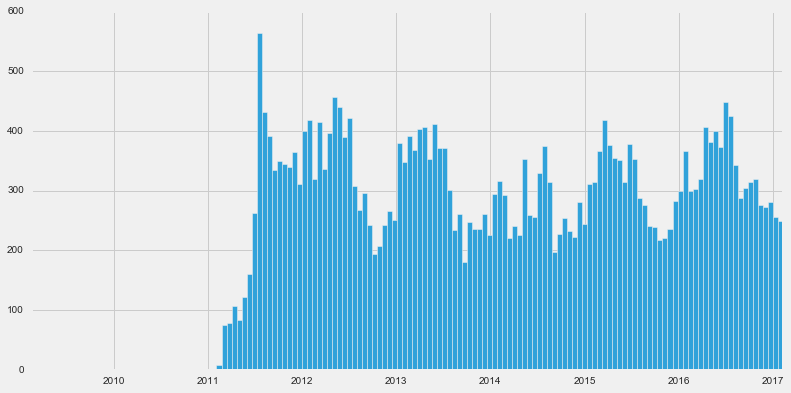

In [23]:
# data by date
pd.to_datetime(df.reportdate).hist(bins=150)

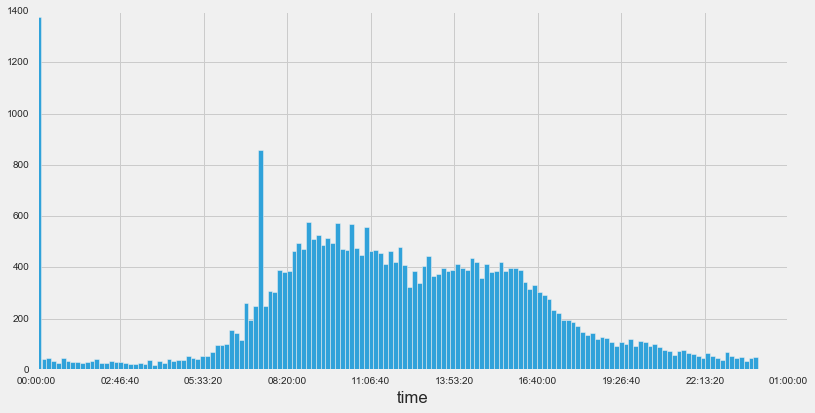

In [24]:
# data by time
pd.to_datetime(df.reportdate).apply(lambda x:x.time()).hist(bins=150)

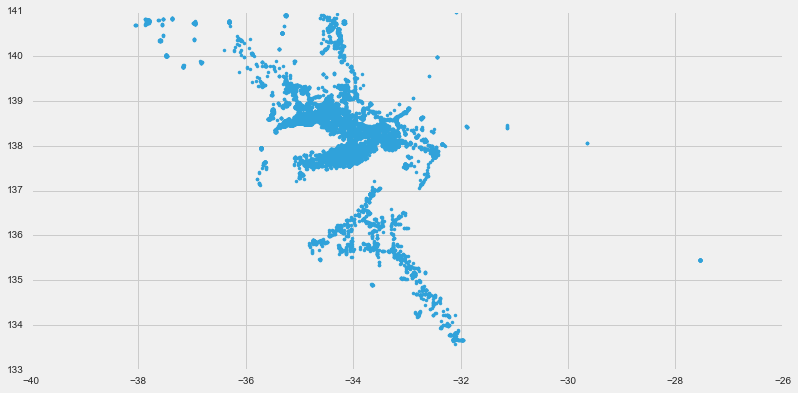

In [25]:
# scatter plot of locations
plt.plot(df.Latitude_Y, df.Longitude_X, '.')

In [26]:
# look at a sampling on a map
import folium
m = folium.Map([df.Latitude_Y.mean(), df.Longitude_X.mean()], zoom_start=10, tiles='cartodbpositron')
folium.GeoJson(gdf.sample(100)).add_to(m)
m